# Stock Spans

Chapter 1 of [Real World Algorithms](https://mitpress.mit.edu/books/real-world-algorithms).

---

> Panos Louridas<br />
> Athens University of Economics and Business

# Stacks in Python

There is no special stack data structure in Python, as all the required functionality is provided by [lists](https://docs.python.org/3/tutorial/datastructures.html#more-on-lists).

We push something on the stack by appending it to the end of the list, calling `append()` on the list.

We pop something from the stack by calling `pop()` on the list.

In [1]:
stack = [3, 4, 5]
stack.append(6)
stack.append(7)
stack

[3, 4, 5, 6, 7]

In [2]:
stack.pop()

7

In [3]:
stack

[3, 4, 5, 6]

In [4]:
stack.pop()

6

In [5]:
stack

[3, 4, 5]

In [6]:
stack.pop()

5

In [7]:
stack

[3, 4]

# The Stock Span Problem in Python

We will work with data for the Dow Jones Industrial Average (DJIA) of the New York Stock Exchange.

Before we start, let us see how the DJIA has evolved over time.

The following lines require knowledge of special Python libraries; don't worry if you don't understand them.

If you do want to run them, you have to install the [`pandas`](http://pandas.pydata.org/) and [`matplotlib`](https://matplotlib.org/) libraries, and enter them in a Jupyter notebook.

The file [djia.csv](djia.csv) contains the DJIA from February 16, 1885 to 2020. The data was retrieved from MeasuringWorth (Samuel H. Williamson, "Daily Closing Values of the DJA in the United States, 1885 to Present," MeasuringWorth, 2020
URL: <https://www.measuringworth.com/datasets/DJA/>).

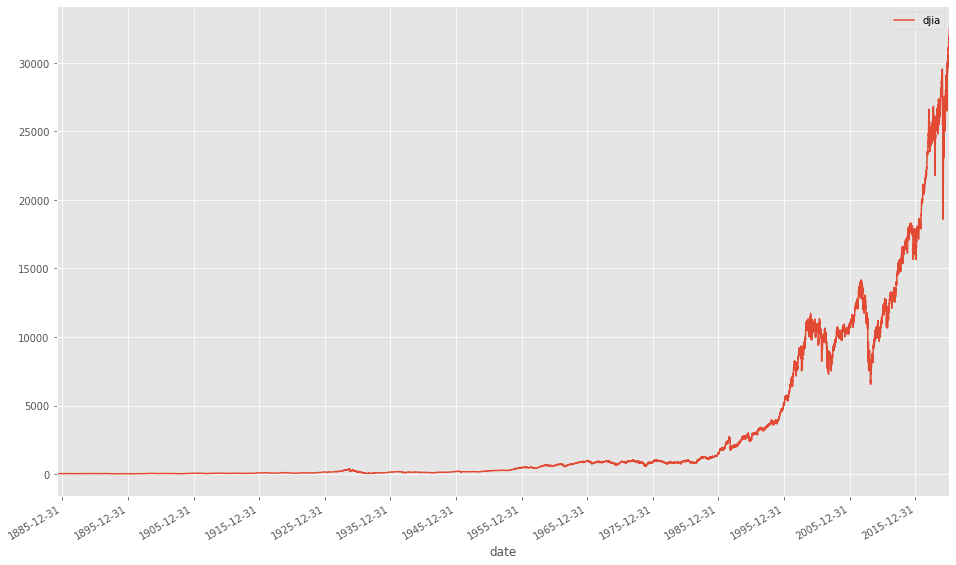

In [8]:
import pandas as pd
import matplotlib
import matplotlib.dates as mdates

%matplotlib inline
matplotlib.style.use('ggplot')

df = pd.read_csv("djia.csv", comment="#", parse_dates=[0], index_col=0, names=["date", "djia"])
plt = df.plot(figsize=(16, 10))
plt.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
min_x = df.index.min()
max_x = df.index.max()
plt.set_xlim([min_x, max_x])
ticks = pd.date_range(start=min_x, end=max_x, freq='10A')
_ = plt.set_xticks(ticks)

Now back to basics.

The following Python function implements the simple stock span algorithm.

It takes as input a list `quotes` with the DJIA closing values, one per day.

It returns a list `spans` with the stock spack for every day.

In [9]:
def simple_stock_span(quotes):
    spans = []
    for i in range(len(quotes)):
        k = 1
        span_end = False
        while i - k >= 0 and not span_end:
            if quotes[i - k] <= quotes[i]:
                k += 1
            else:
                span_end = True
        spans.append(k)
    return spans

To use this function we must have constructed the `quotes` list.

The following function takes a file that contains the DJIA data. The file has the following format:
```
3/9/2021,31832.74
3/10/2021,32297.02
3/11/2021,32485.59
```

Each quote is preceded by the corresponding date, in month-day-year format. Also, some lines in the file start with `#`. These are comments and we will ignore them.

So our function will read the file line-by-line and return a list `dates` with the dates on which we have quotes and a list `quotes` that will contain the second item of each line (the DJIA value).

To split the line, we use the [`split()`](https://docs.python.org/3/library/stdtypes.html#str.split) function, which splits a string into pieces, breaking the string at the places it finds the separator that we specify. The expression `parts = line.split(',')` breaks the line at the comma and returns the pieces in `parts`; `parts[0]` is the date and `parts[1]`, or equivalently `parts[-1]`, is the quote. We will ignore any lines that cannot be split into two parts (for example empty lines). 

As we noted, the dates are in month-day-year format. We will convert them to the year-month-day format. To do that, we need to split each date at `/`. The expression `month, day, year = parts[0].split('/')` will break the date in three parts and assign each one of them to a separate variable. Then, we assemble them in the required order by calling `'/'.join((year, month, day))`, and we append the resulting date into the `dates` list. We also append the quote value in the `quotes` list. As this is a string when we read it from the file, we convert it to a float with a call to `float()`.

At the end, the function will return a list of dates and a list containing the corresponding quotes.

In [10]:
def read_quotes(filename):
    dates = []
    quotes = []
    with open(filename) as quotes_file:
        for line in quotes_file:
            if line.startswith('#'):
                continue
            parts = line.split(',')
            if len(parts) != 2:
                continue
            month, day, year = parts[0].split('/')
            date = '/'.join((year, month, day))
            dates.append(date)
            quotes.append(float(parts[-1]))
    return dates, quotes

Then for the file [djia.csv](djia.csv) we do the following:

In [11]:
dates, quotes = read_quotes("djia.csv")

Let's check how many lines we've read:

In [12]:
len(quotes)

37224

We can call `simple_stock_span(quotes)` and print some stock spans.

In [13]:
spans_simple = simple_stock_span(quotes)
print(spans_simple[-10:])

[1, 3, 1, 1, 1, 4, 8, 9, 37223, 37224]


Out of curiosity, let's find the greatest stock span, using Python's `max()` function.

In [14]:
max_value = max(spans_simple)
max_value

37224

Then we want to find the date when this happened. To do that, we need to get the index of the `max_value` in `spans`, as this will be the same with the index of the date in which it occurred in `dates`. To find the first index of an item in a list, we use the `index()` method.

In [15]:
max_value_indx = spans_simple.index(max_value)
dates[max_value_indx]

'2021/3/11'

Now we will examine how long `simple_stock_span(quotes)` takes to run.

We will run it 10 times and report the average.

In [16]:
import time

iterations = 10
start = time.time()
for i in range(iterations):
    simple_stock_span(quotes)
end = time.time()
    
time_simple = (end - start) / iterations
print(time_simple)

5.335288190841675


We will contrast that result with a stack-based implementation.

The stack-based stock span algorithm in Python is as follows:

In [17]:
def stack_stock_span(quotes):
    spans = [1]
    s = []
    s.append(0)
    for i in range(1, len(quotes)):
        while len(s) != 0 and quotes[s[-1]] <= quotes[i]:
            s.pop()
        if len(s) == 0:
            spans.append(i+1)
        else:
            spans.append(i - s[-1])
        s.append(i)
    return spans

We call it in the same way:

In [18]:
spans_stack = stack_stock_span(quotes)
print(spans_stack[-10:])

[1, 3, 1, 1, 1, 4, 8, 9, 37223, 37224]


We verify that the two results, `spans_simple` and `spans_stack` are the same.

In [19]:
spans_simple == spans_stack

True

And we can measure the time it takes:

In [20]:
start = time.time()
for i in range(iterations):
    stack_stock_span(quotes)
end = time.time()
    
time_stack = (end - start) / iterations
print(time_stack)

0.018924403190612792


We see that from about 5000 milliseconds we went down to about 18 milliseconds! The difference, of course, is owed to the fact that the second algorithm executes much fewer steps than the first.

In fact, we can have the computer count exactly the number of steps it executes when executing the code. First, we put all the code we want to count in one file; below we have copied the functions we've written and we call `simple_stock_span()` and `stack_stock_span()` once each.

In [21]:
import time

def simple_stock_span(quotes):
    spans = []
    for i in range(len(quotes)):
        k = 1
        span_end = False
        while i - k >= 0 and not span_end:
            if quotes[i - k] <= quotes[i]:
                k += 1
            else:
                span_end = True
        spans.append(k)
    return spans

def stack_stock_span(quotes):
    spans = [1]
    s = []
    s.append(0)
    for i in range(1, len(quotes)):
        while len(s) != 0 and quotes[s[-1]] <= quotes[i]:
            s.pop()
        if len(s) == 0:
            spans.append(i+1)
        else:
            spans.append(i - s[-1])
        s.append(i)
    return spans
    

def read_quotes(filename):
    dates = []
    quotes = []
    with open(filename) as quotes_file:
        for line in quotes_file:
            if line.startswith('#'):
                continue
            parts = line.split(',')
            if len(parts) != 2:
                continue
            month, day, year = parts[0].split('/')
            date = '/'.join((year, month, day))
            dates.append(date)
            quotes.append(float(parts[-1]))
    return dates, quotes

_, quotes = read_quotes("djia.csv") # we use _ for a variable that we
                                    # don't care to use


spans_simple = simple_stock_span(quotes)

spans_stack = stack_stock_span(quotes)

print('spans_simple == spans_stack:', spans_simple == spans_stack)

spans_simple == spans_stack: True


We save the code in a file, say [`stock_spans.py`](stock_spans.py). Then we execute the code with:

```
python -m trace --count -C . stock_span.py
```

This will trace the execution of the program and count the number of times each line is executed---so it will run much longer than normal, don't worry if you see it taking too much time. When it finishes, you will see a file called `stock_span.cover` that contains the counts (you can ignore any other file you may see whose filename ends in `.cover`). If you open the file, you can verify the dramatic difference between the two algorithms:

```
    1: import time
       
    1: def simple_stock_span(quotes):
    1:     spans = []
37225:     for i in range(len(quotes)):
37224:         k = 1
37224:         span_end = False
38611221:         while i - k >= 0 and not span_end:
38573997:             if quotes[i - k] <= quotes[i]:
38538302:                 k += 1
                   else:
35695:                 span_end = True
37224:         spans.append(k)
    1:     return spans
       
    1: def stack_stock_span(quotes):
    1:     spans = [1]
    1:     s = []
    1:     s.append(0)
37224:     for i in range(1, len(quotes)):
74446:         while len(s) != 0 and quotes[s[-1]] <= quotes[i]:
37223:             s.pop()
37223:         if len(s) == 0:
 1528:             spans.append(i+1)
               else:
35695:             spans.append(i - s[-1])
37223:         s.append(i)
    1:     return spans
           
       
    1: def read_quotes(filename):
    1:     dates = []
    1:     quotes = []
    1:     with open(filename) as quotes_file:
37234:         for line in quotes_file:
37233:             if line.startswith('#'):
    9:                 continue
37224:             parts = line.split(',')
37224:             if len(parts) != 2:
                       continue
37224:             month, day, year = parts[0].split('/')
37224:             date = '/'.join((year, month, day))
37224:             dates.append(date)
37224:             quotes.append(float(parts[-1]))
    1:     return dates, quotes
       
    1: _, quotes = read_quotes("djia.csv") # we use _ for a variable that we
                                           # don't care to use
       
       
    1: spans_simple = simple_stock_span(quotes)
       
    1: spans_stack = stack_stock_span(quotes)
       
    1: print('spans_simple == spans_stack:', spans_simple == spans_stack)
```